In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

# 스마트카드 데이터
SMART_CARD = pd.read_csv('./data/SMART_CARD.csv', header = None)

# 공공데이터포털
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0) # 전체 노선 기본정보 조회
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0) # 전체노선별경유정류소 정보 조회

# 정류장 데이터
bus_sttn = pd.read_csv('./data/bus_sttn.csv')

In [2]:
def smart_card_data_preprocessing(exdata):
    exdata.columns = ['SERIAL_NO', 'CARD_NO', 'GETON_YMD', 'GETON_TM', 'BUS_ROUTE_ID', 'BUS_CO_ID', 'BUS_CAR_ID', 'GETON_BUS_STTN_ID', 'GETOFF_BUS_STTN_ID',
                        'DRVR_ID', 'TRANSACTION_ID', 'TR_MEANS_TYPE', 'USR_TYPE', 'DRVN_START_YMD', 'DRVN_START_TM', 'GETOFF_YMD', 'GETOFF_TM', 'GETON_CALC_YMD',
                        'GETOFF_CALC_YMD', 'GETON_PAY', 'GETOFF_PAY', 'TRANSF_CNT', 'USR_CNT']
    exdata.drop(labels = ['SERIAL_NO', 'DRVR_ID','TRANSACTION_ID','USR_TYPE','DRVN_START_YMD','BUS_CO_ID','DRVN_START_TM','GETOFF_YMD','GETOFF_TM','GETON_CALC_YMD','GETOFF_CALC_YMD', 'GETON_PAY','GETOFF_PAY','TRANSF_CNT','GETOFF_BUS_STTN_ID'], axis = 1, inplace = True)


    exdata['GETON_TM'] = exdata['GETON_TM'].apply(lambda x: str(x).zfill(6)) # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기

    # datetime 형식으로 변환 및 새로운 column 생성
    exdata['GETON_DATETIME'] = pd.to_datetime(exdata['GETON_YMD'].astype(str) + exdata['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')

    exdata['DAY'] = exdata['GETON_DATETIME'].dt.day
    exdata['WEEKDAY'] = exdata['GETON_DATETIME'].dt.weekday  

    # 급행/지선/간선만 필터링
    exdata = exdata[exdata['TR_MEANS_TYPE'].isin([675,676])]

    # 도시 노선만 사용하기 위해
    values_to_remove = [30300147, 30300148, 30300141, 30300137, 30300149, 30300103]
    exdata = exdata[~exdata['BUS_ROUTE_ID'].isin(values_to_remove)]

    # 평일만 추출
    weekday_values = [0, 1, 2, 3, 4]
    exdata = exdata[exdata['WEEKDAY'].isin(weekday_values)]

    # 6/6일 제거 / 6/19일 제거[결측치]
    exdata = exdata[exdata['DAY'] != 6]
    exdata = exdata[exdata['DAY'] != 19]

    # # 비가 온 날 제거
    # exdata = exdata[~exdata['DAY'].isin([26,29])]

    # 사용한 행 제거
    exdata.drop(labels = ['GETON_YMD','GETON_TM','TR_MEANS_TYPE','USR_CNT','WEEKDAY'], axis = 1, inplace = True)
    
    return exdata

In [3]:
SMART_CARD_DATA = smart_card_data_preprocessing(SMART_CARD)
SMART_CARD_DATA.head(2)

,CARD_NO,BUS_ROUTE_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,DAY
3,804099084,30300053,130752377,8005978,2023-06-01 05:20:33,1
35,929954937,30300043,130759616,8001243,2023-06-01 05:30:22,1


### 시각화

In [4]:
SMART_CARD_DATA['GETON_HOUR'] = SMART_CARD_DATA['GETON_DATETIME'].dt.hour
# 출/퇴근 시간대만 필터링
SMART_CARD_DATA_ = SMART_CARD_DATA[SMART_CARD_DATA['GETON_HOUR'].isin([7,8,16,17,18])]
SMART_CARD_DATA_

,CARD_NO,BUS_ROUTE_ID,BUS_CAR_ID,GETON_BUS_STTN_ID,GETON_DATETIME,DAY,GETON_HOUR
16361,803929993,30300070,130752605,8002825,2023-06-01 07:00:00,1,7
16362,803166584,30300037,130759023,8005517,2023-06-01 07:00:00,1,7
16363,911563091,30300071,130759180,8002572,2023-06-01 07:00:00,1,7
16364,934924962,30300069,130759715,8003044,2023-06-01 07:00:00,1,7
16365,549151960,30300096,130752063,8002553,2023-06-01 07:00:00,1,7
...,...,...,...,...,...,...,...
10698195,745323770,30300077,130752010,8002434,2023-06-30 18:59:59,30,18
10698196,541380065,30300087,130759614,8002088,2023-06-30 18:59:59,30,18
10698198,918362716,30300054,130759382,8002452,2023-06-30 18:59:59,30,18
10698199,781295883,30300036,130759520,8002407,2023-06-30 18:59:59,30,18


In [5]:
getrouteinfoall_merge_df = getrouteinfoall[['ALLO_INTERVAL','ROUTE_CD','ROUTE_NO']]

In [6]:
allo_interval_merge = SMART_CARD_DATA_.merge(getrouteinfoall_merge_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
allo_interval_merge = allo_interval_merge[['ROUTE_NO','CARD_NO','ALLO_INTERVAL']]
bus_usage = allo_interval_merge.groupby("ROUTE_NO").size().reset_index(name="USAGE_COUNT")
bus_usage_merge = bus_usage.merge(getrouteinfoall_merge_df, left_on = 'ROUTE_NO', right_on = 'ROUTE_NO')
bus_usage_merge = bus_usage_merge[['ROUTE_NO','USAGE_COUNT','ALLO_INTERVAL']]
bus_usage_merge['ALLO_INTERVAL'] = bus_usage_merge['ALLO_INTERVAL'].astype(int)
# bus_usage_merge['USAGE_COUNT'] = (bus_usage_merge['USAGE_COUNT']/18).astype(int)
bus_usage_merge_work = bus_usage_merge[bus_usage_merge['ROUTE_NO']!='2']

In [7]:
allo_interval_merge = SMART_CARD_DATA.merge(getrouteinfoall_merge_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
allo_interval_merge = allo_interval_merge[['ROUTE_NO','CARD_NO','ALLO_INTERVAL']]
bus_usage = allo_interval_merge.groupby("ROUTE_NO").size().reset_index(name="USAGE_COUNT")
bus_usage_merge = bus_usage.merge(getrouteinfoall_merge_df, left_on = 'ROUTE_NO', right_on = 'ROUTE_NO')
bus_usage_merge = bus_usage_merge[['ROUTE_NO','USAGE_COUNT','ALLO_INTERVAL']]
bus_usage_merge['ALLO_INTERVAL'] = bus_usage_merge['ALLO_INTERVAL'].astype(int)
bus_usage_merge_all = bus_usage_merge[bus_usage_merge['ROUTE_NO']!='2']

산점도 시각화

In [8]:
bus_usage_merge_work['USAGE_COUNT'] = bus_usage_merge_work['USAGE_COUNT']/5
bus_usage_merge_work

,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL
0,101,5932.6,20
1,102,30031.6,7
2,103,14545.0,13
3,104,4366.8,20
4,105,18637.2,9
...,...,...,...
60,802,9283.6,18
61,911,2780.8,25
62,912,3306.4,19
63,916,4619.6,22


In [9]:
bus_usage_merge_all['USAGE_COUNT'] = bus_usage_merge_all['USAGE_COUNT']/19
bus_usage_merge_all

,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL
0,101,3943.157895,20
1,102,19274.157895,7
2,103,9317.473684,13
3,104,2842.526316,20
4,105,12400.105263,9
...,...,...,...
60,802,5918.894737,18
61,911,1719.263158,25
62,912,1856.736842,19
63,916,2732.473684,22


회귀선 시각화

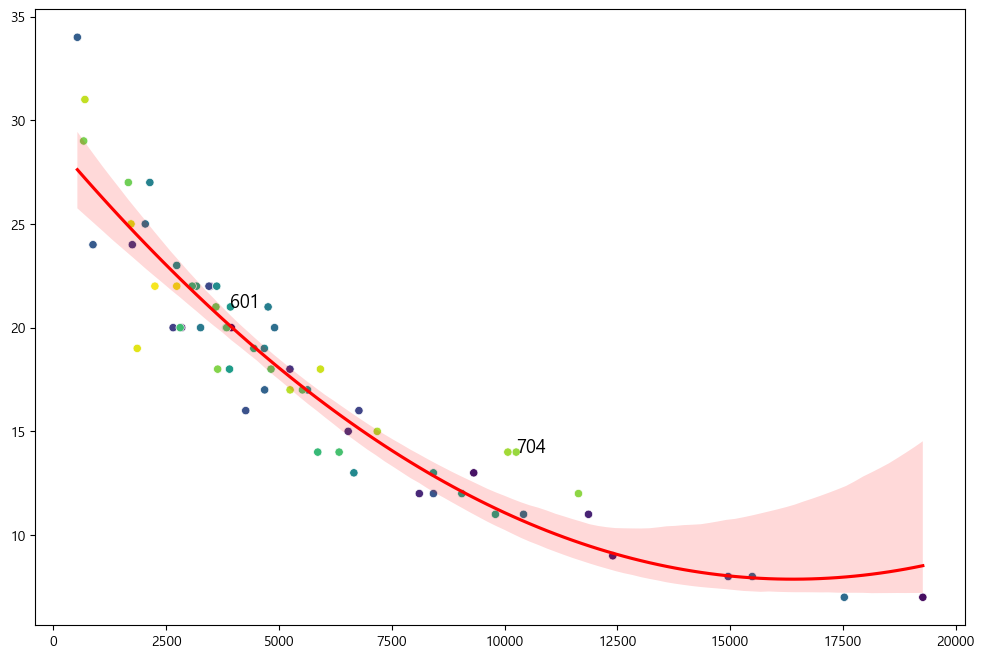

In [12]:
import seaborn as sns

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프 그리기
sns.scatterplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")

# 2차 곡선 회귀선 그리기
sns.regplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, order=2, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기 (601번과 702번 노선만)
for route, usage, interval in zip(bus_usage_merge_all["ROUTE_NO"], bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    if route in ['601', '704']:
        plt.annotate(route,
                     xy=(usage, interval),
                     xytext=(0, 0),
                     textcoords='offset points',
                     fontsize=13)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("")
plt.ylabel("")
# 범례 제거
plt.legend().remove()

plt.show()


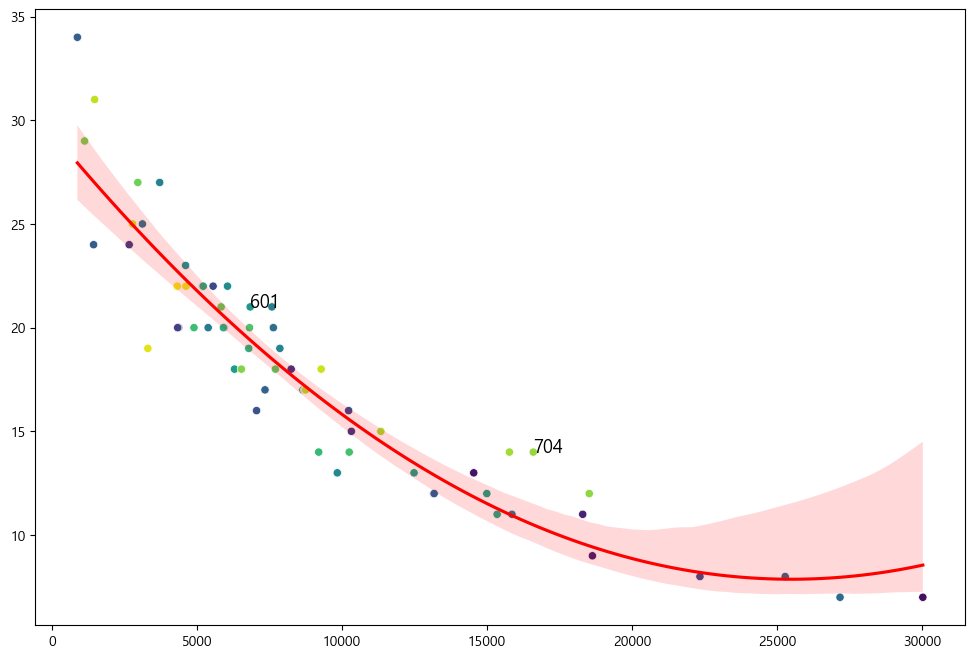

In [13]:
# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프 그리기
sns.scatterplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")

# 2차 곡선 회귀선 그리기
sns.regplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, order=2, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기 (601번과 702번 노선만)
for route, usage, interval in zip(bus_usage_merge_work["ROUTE_NO"], bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"]):
    if route in ['601', '704']:
        plt.annotate(route,
                     xy=(usage, interval),
                     xytext=(0, 0),
                     textcoords='offset points',
                     fontsize=13)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("")
plt.ylabel("")
# 범례 제거
plt.legend().remove()

plt.show()


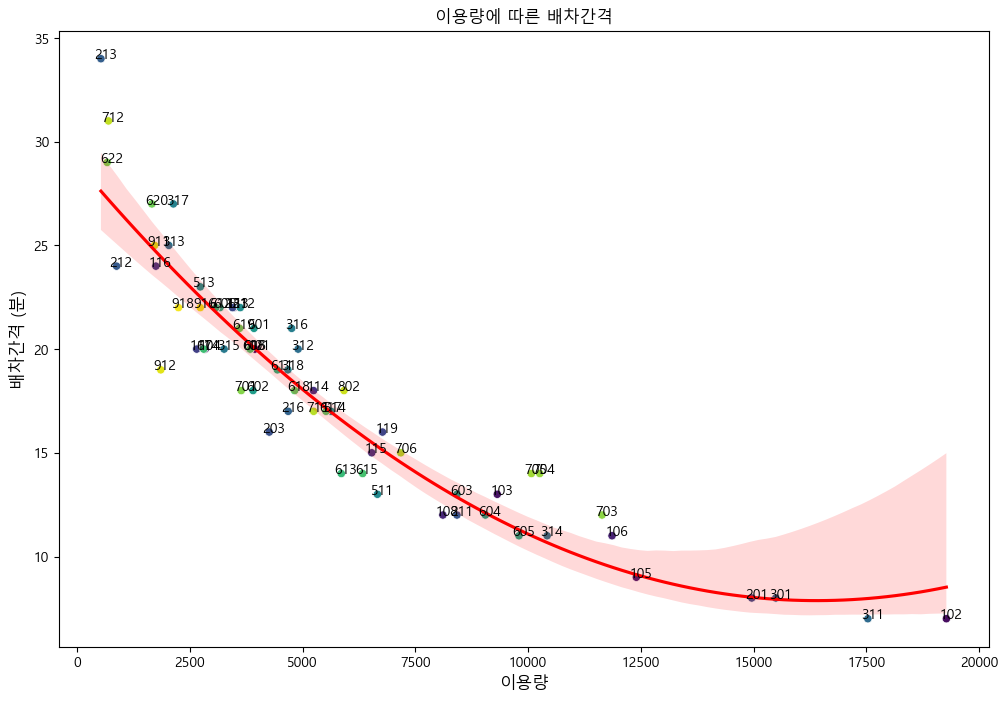

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프 그리기
sns.scatterplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")

# 2차 곡선 회귀선 그리기
sns.regplot(data=bus_usage_merge_all, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, order=2, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_all["ROUTE_NO"], bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=10)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량", fontsize = 12)
plt.ylabel("배차간격 (분)", fontsize = 12)
plt.title("이용량에 따른 배차간격", fontsize = 12)

# 회귀선의 방정식 계산
a, b, c = np.polyfit(bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"], 2)  # 2차 곡선이므로 2로 수정

# 회귀선과의 거리 계산 및 데이터프레임에 추가
distances = []
for x, y in zip(bus_usage_merge_all["USAGE_COUNT"], bus_usage_merge_all["ALLO_INTERVAL"]):
    y_pred = a * x**2 + b * x + c  # 2차 곡선 방정식
    distance = y - y_pred
    distances.append(distance)

# 거리를 데이터프레임에 추가
bus_usage_merge_all["Distance"] = distances

# 범례 제거
plt.legend().remove()

plt.show()

# 거리가 추가된 데이터프레임 출력
# print(bus_usage_merge_all.head())


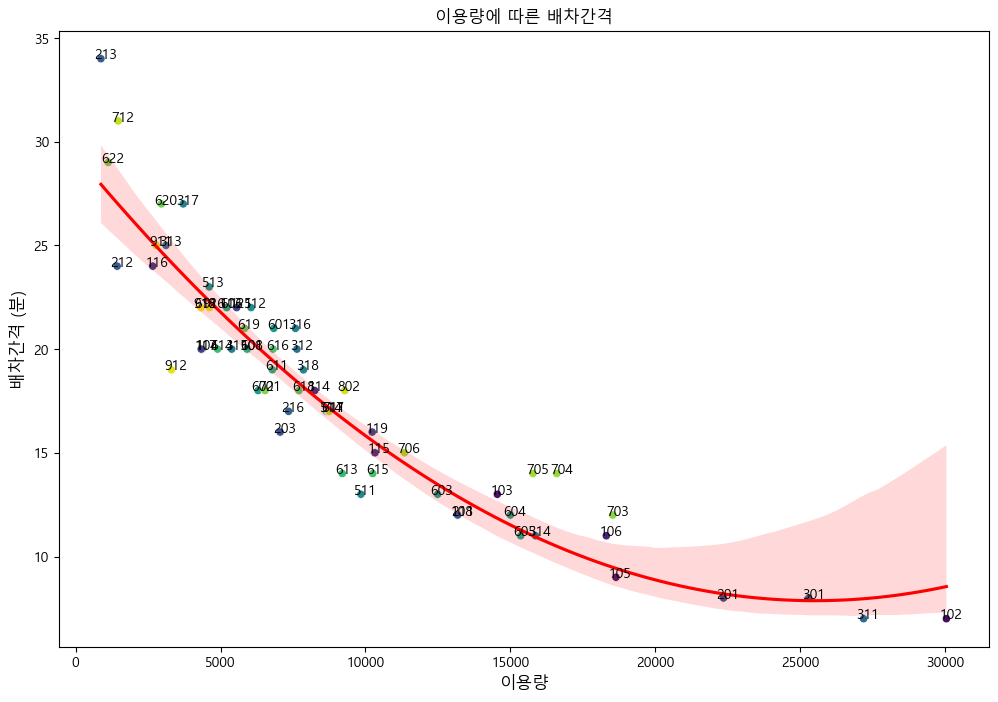

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 산점도 그래프 그리기
sns.scatterplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", hue="ROUTE_NO", palette="viridis")

# 2차 곡선 회귀선 그리기
sns.regplot(data=bus_usage_merge_work, x="USAGE_COUNT", y="ALLO_INTERVAL", scatter=False, order=2, color='black', line_kws={"color": "red"})

# 데이터 포인트에 레이블 달기
for route, usage, interval in zip(bus_usage_merge_work["ROUTE_NO"], bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"]):
    plt.annotate(route,
                 xy=(usage, interval),
                 xytext=(-5, 0),
                 textcoords='offset points',
                 fontsize=10)

# X, Y 축 레이블 및 타이틀 설정
plt.xlabel("이용량", fontsize = 12)
plt.ylabel("배차간격 (분)", fontsize = 12)
plt.title("이용량에 따른 배차간격", fontsize = 12)

# 회귀선의 방정식 계산
a, b, c = np.polyfit(bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"], 2)  # 2차 곡선이므로 2로 수정

# 회귀선과의 거리 계산 및 데이터프레임에 추가
distances = []
for x, y in zip(bus_usage_merge_work["USAGE_COUNT"], bus_usage_merge_work["ALLO_INTERVAL"]):
    y_pred = a * x**2 + b * x + c  # 2차 곡선 방정식
    distance = y - y_pred
    distances.append(distance)

# 거리를 데이터프레임에 추가
bus_usage_merge_work["Distance"] = distances

# 범례 제거
plt.legend().remove()

plt.show()

# 거리가 추가된 데이터프레임 출력
# print(bus_usage_merge_work.head())


In [16]:
# 새로운 열 'coordinate'를 생성하여 좌표를 저장
bus_usage_merge_all['coordinate'] = list(zip(bus_usage_merge_all['USAGE_COUNT'], bus_usage_merge_all['ALLO_INTERVAL']))

# 'ROUTE_NO'를 기준으로 그룹화하여 각 노선별 좌표 리스트를 저장
coordinates_by_route = bus_usage_merge_all.groupby('ROUTE_NO')['coordinate'].apply(list).reset_index()

# 각 노선의 좌표 리스트를 출력
for index, row in coordinates_by_route.iterrows():
    route_no = row['ROUTE_NO']
    coordinates = row['coordinate']


In [20]:
# 318
print(bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO']=='318']['Distance'].values[0]) # 전체 시간대
print(bus_usage_merge_work[bus_usage_merge_work['ROUTE_NO']=='318']['Distance'].values[0]) # 출/퇴근 시간대
print(bus_usage_merge_work[bus_usage_merge_work['ROUTE_NO']=='318']['Distance'].values[0] - bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO']=='318']['Distance'].values[0]) #차이

0.35298841212367904
0.8281539784650889
0.47516556634140983


In [21]:
# 317
print(bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO']=='317']['Distance'].values[0]) # 전체 시간대
print(bus_usage_merge_work[bus_usage_merge_work['ROUTE_NO']=='317']['Distance'].values[0]) # 출/퇴근 시간대
print(bus_usage_merge_work[bus_usage_merge_work['ROUTE_NO']=='317']['Distance'].values[0] - bus_usage_merge_all[bus_usage_merge_all['ROUTE_NO']=='317']['Distance'].values[0]) #차이

3.1801394184631704
3.4176271428829352
0.23748772441976485


In [22]:
# 회귀선과 거리가 먼 노선 601
close_to_the_regression_line = bus_usage_merge_all.sort_values('Distance').head(10)
close_to_the_regression_line = close_to_the_regression_line[close_to_the_regression_line['ALLO_INTERVAL']<21]
close_to_the_regression_line = close_to_the_regression_line[close_to_the_regression_line['USAGE_COUNT']<=3923.421053] # 601번 기준
close_to_the_regression_line.sort_values('Distance',ascending=True).head(3)

,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance,coordinate
62,912,1856.736842,19,-5.452665,"(1856.7368421052631, 19)"
11,117,2652.684211,20,-2.687025,"(2652.684210526316, 20)"
53,701,3640.473684,18,-2.634023,"(3640.4736842105262, 18)"


In [23]:
# 회귀선과 거리가 먼 노선 704
close_to_the_regression_line_704 = bus_usage_merge_all.sort_values('Distance').head(10)
close_to_the_regression_line_704 = close_to_the_regression_line_704[(close_to_the_regression_line_704['USAGE_COUNT']>=3923.421053) & (close_to_the_regression_line_704['USAGE_COUNT']<=10258.736842)] # 704번 기준
close_to_the_regression_line_704.sort_values('Distance',ascending = True)

,ROUTE_NO,USAGE_COUNT,ALLO_INTERVAL,Distance,coordinate
17,203,4262.368421,16,-3.420006,"(4262.368421052632, 16)"
44,613,5859.105263,14,-2.580835,"(5859.105263157895, 14)"
31,511,6660.210526,13,-2.307050,"(6660.210526315789, 13)"


---